In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import laspy
import fiona
import shapely
import shapely.geometry
import rasterio
from pprint import pprint
from tqdm import tnrange, tqdm_notebook
import rasterio.crs
from glob import glob
from time import sleep
import gc
import traceback

# Open the Vector Data
The vector data is used to determine the region of interest. It was manually labeled with all transformer boxes annotated clockwise(counter-clockwise?) facing the road. The projection srs(spatial reference system) is epsg:26949

In [5]:
VECTOR_DATA_FN = r'/home/femianjc/shared/srp/boxes11/boxes_section11.shp'
assert os.path.isfile(VECTOR_DATA_FN)
# These are the points we manually marked
vector_file = fiona.open(VECTOR_DATA_FN)

GROUND_FN = r'/home/femianjc/shared/srp/ground/merged_ground.asc'
assert os.path.isfile(GROUND_FN)

In [7]:
OUTPUT_FN = './stack2.vrt'
SLICE_THICKNESS = 0.313

OUTPUT_METERS_PER_PIXEL = .05 # five centimeters, about 2 inches
OUTPUT_PADDING = 5 # expand output region 5 meters (to fit a local neighborhood into the image at the edges)

In [16]:
minx, miny, maxx, maxy = vector_file.bounds

# Expand the region so that a local window centered at points on the edges
# does not go outside the grid
minx -= OUTPUT_PADDING
miny -= OUTPUT_PADDING
maxx += OUTPUT_PADDING
maxy += OUTPUT_PADDING

print "Region of interest (based on vector data)"
print minx, miny, "--", maxx, maxy 

Region of interest (based on vector data)
231638.410976 251008.999357 -- 233216.25982 252568.834735


In [13]:
width_in_meters = maxx-minx
height_in_meters = maxy-miny
print 'width (m):', width_in_meters
print 'height (m):', height_in_meters

width (m): 1577.84884394
height (m): 1559.83537839


In [14]:
grid_width = int(round(width_in_meters/OUTPUT_METERS_PER_PIXEL))
grid_height = int(round(height_in_meters/OUTPUT_METERS_PER_PIXEL))
print 'grid width (cols):', grid_width
print 'grid height (rows):', grid_height

grid width (cols): 31557
grid height (rows): 31197


In [331]:
pattern = os.path.join(r'/media/femianjc/srpdisk/ASU_LiDAR_Processing/section11/tiled/50/*.laz')
jobs = glob(pattern)
print len(jobs)

1680


In [18]:
def save_stack(stack, las_fn, min_point, max_point, las_width, las_height):
    """Give a las file name, and a raster 'stack' computed bases on it, save 
    output to an appropriately named location. 
    
    When this is called, the LIDAR data has already been read and an ndarray called 'stack' has been
    created based on it. This function just determines the files name and location and saves it to disk. 
    
    :param[in] stack: The raster file. 
    :param[in] las_fn: Tha name of the LAS file that was used to generate the stack/raster file. 
    :param[in] min_point: The miimim LIDAR point in the stack. 
    :param[in] max_point: The maximum LIDAR point in the stack
    :param[in] las_width: The width of the stack?
    :param[in] las_height: The height of the stack?
    
    :return: The path to the file that we saves. 
    """
    output_transform = rasterio.transform.from_bounds(min_point[0], min_point[1],
                                                      max_point[0], max_point[1], 
                                                      las_width, las_height)
    output_crs = rasterio.crs.from_epsg(26949)

    output_fn = os.path.basename(las_fn)[:-3] + 'tif'
    
    # Replace output file if it already existed
    if os.path.isfile(output_fn):
        os.remove(output_fn)
        
    #Create a new raster file with the right shape & geo-location
    output_file = rasterio.open(output_fn, 'w', 
                            driver=u'GTiff', 
                            crs = output_crs,
                            transform=output_transform,
                            dtype=rasterio.uint16, 
                            count=3, 
                            width=las_width, 
                            height=las_height)
    
    # Write out the stack-raster-data and close the file
    output_file.write(indexes=(1,2,3), src=stack.astype(np.uint16))
    output_file.close()
    
    
    return output_fn

In [17]:
def process_las_file(las_fn):
    """Processes a single LAS/LAZ file
    This function either returns the name of a file, or an exception object. 
    It is intended to be used in multiproccessing.Pool.imap
    """
    output_fn = ''
    gc.collect()
    try:
        las_file = laspy.file.File(las_fn)
        X = las_file.x
        Y = las_file.y
        Z = las_file.z
        min_point = las_file.header.min
        max_point = las_file.header.max
        las_file.close()
        
        if max_point[0] < minx or min_point[0] > maxx or max_point[1] < miny or min_point[1] > maxy:
            return "Skipping {}, out-of-bounds file".format(os.path.split(las_fn)[1])

        las_min_x = int(floor((min_point[0] - minx) / OUTPUT_METERS_PER_PIXEL))
        las_min_y = int(floor((min_point[1] - miny) / OUTPUT_METERS_PER_PIXEL))
        las_max_x = int(floor((max_point[0] - minx) / OUTPUT_METERS_PER_PIXEL))
        las_max_y = int(floor((max_point[1] - miny) / OUTPUT_METERS_PER_PIXEL))
        las_width = las_max_x - las_min_x + 1
        las_height = las_max_y - las_min_y + 1

        ground_file = rasterio.open(GROUND_FN)
        ground_min_x, ground_min_y = ~(ground_file.affine)*(min_point[0], min_point[1])
        ground_max_x, ground_max_y = ~(ground_file.affine)*(max_point[0], max_point[1])
        ground_min_x = int(round(ground_min_x))
        ground_min_y = int(round(ground_min_y))
        ground_max_x = int(round(ground_max_x))
        ground_max_y = int(round(ground_max_y))

        flipped = False
        if ground_max_y <  ground_min_y:
            ground_min_y, ground_max_y = ground_max_y, ground_min_y
            flipped = True

        ground_width = ground_max_x - ground_min_x + 1
        ground_height = ground_max_y - ground_min_y + 1

        ground = ground_file.read(1, 
                                  window=((ground_min_y, ground_max_y + 1), (ground_min_x, ground_max_x + 1)), 
                                  boundless=True)
        if flipped:
            ground = ground[::-1,:] 
        ground_file.close()

        # Find the rows and columsn of each LIDAR point in the _output_ file. 
        C = np.floor(((X - minx)/OUTPUT_METERS_PER_PIXEL)).astype(int) - las_min_x
        R = np.floor(((Y - miny)/OUTPUT_METERS_PER_PIXEL)).astype(int) - las_min_y

        # Subtract the corresponding value from the _ground_ file to get height-above-ground. 
        height_above_ground = Z - ground[(R*ground_height)/las_height, (C*ground_width)/las_width]      

        # Determine how many slices above the ground each point is at. 
        level = np.floor((height_above_ground)/SLICE_THICKNESS).astype(int)
        
        def _generate_level(lvl):
            bc = np.bincount(R[level==lvl]*las_width + C[level==lvl], minlength=las_width*las_height)
            output = bc.reshape((las_height, las_width)).astype(float)
            return output

        # Count the number of LIDAR points in each slice (for slices 1, 2, 3). 
        # Note this does not include 0
        stack = np.stack([_generate_level(lvl) for lvl in 1,2,3])

        # I seem to be working upside-down...
        output_fn = save_stack(stack[:,::-1,:], las_fn,  min_point, max_point, las_width, las_height)
    except e:
        return (e, traceback.format_exc())
    
    return output_fn 

# Check the Result


:NOTE:  Somehow fiona was unable to open the shapefile, so I converted it to a GeoJSON file with:
```bash
    ogr2ogr boxe_section11.json boxes_section11.shp -f GeoJSON 
```

In [97]:
output_ds = rasterio.open('/home/femianjc/shared/srp/try2/stack.vrt')
vector_file = fiona.open('/home/femianjc/shared/srp/boxes11/boxes_section11-epsg26949.json.geojson')

print vector_file.meta
print 'Number of features: ', len(vector_file)

{'crs': {'init': u'epsg:26949'}, 'driver': u'GeoJSON', 'schema': {'geometry': 'LineString', 'properties': OrderedDict([(u'id', 'str')])}}
Number of features:  226


In [33]:
hotspots = [array(f['geometry']['coordinates']).mean(0) for f in vector_file if f['geometry'] is not None]

In [34]:
hs = hotspots[randint(len(hotspots))]
ctr = hs

[ 233115.60814053  252214.98431531]
[30343  7700]


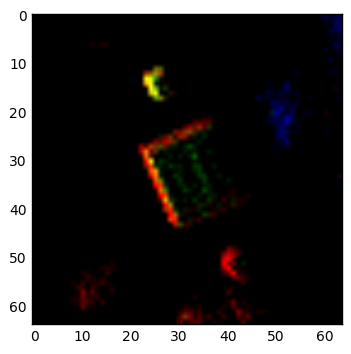

In [35]:
print ctr
cr = np.asarray(~output_ds.affine * ctr).astype(int)
c, r = cr
print cr

data = output_ds.read(window=((r-32, r+32), (c-32, c+32)), boundless=True)

imshow((data.transpose(1,2,0)/20.).clip(0, 1))

In [122]:
import pyproj

In [129]:
# rgb = rasterio.open('/home/femianjc/shared/srp/rgb/rgb.vrt')
rgb = rasterio.open('/home/femianjc/Projects/SRP/transformer_box/sec11-26949.tif')

In [124]:
rgb_ctr = pyproj.transform(EPSG26949, EPSG2223, ctr[0], ctr[1])
print ctr, rgb_ctr

[ 233115.60814053  252214.98431531] (764814.9873376982, 827476.9826617875)


[9143 6278]


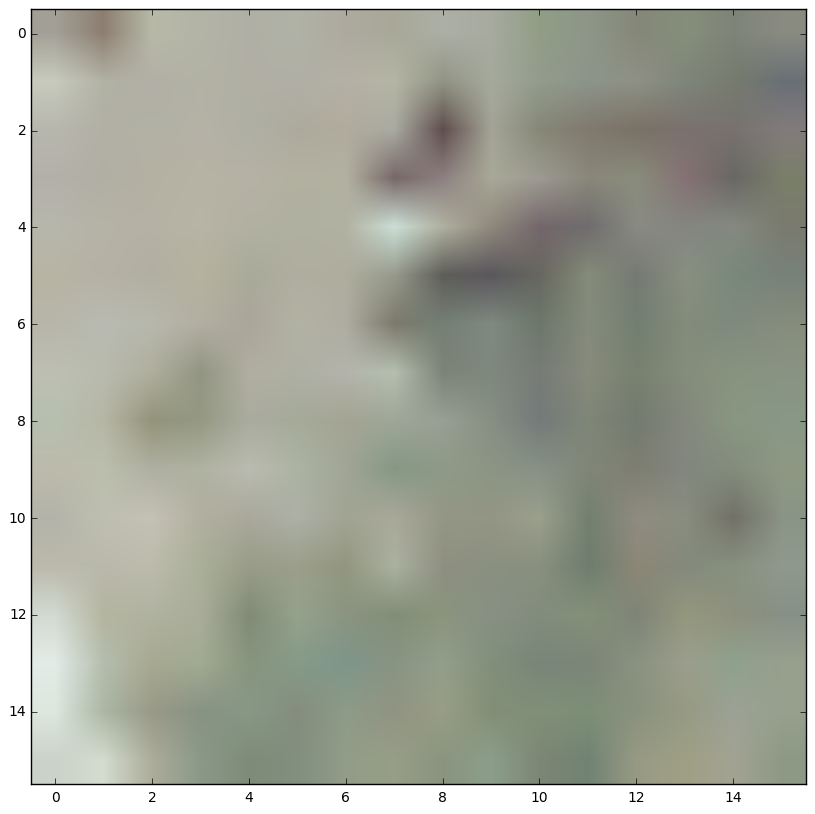

In [125]:
rgb_cr = np.asarray(~rgb.affine * rgb_ctr).astype(int)
print rgb_cr
rgb_data = rgb.read(window=((rgb_cr[1]-8, rgb_cr[1]+8), (rgb_cr[0]-8, rgb_cr[0]+8)), boundless=True)
imshow(rgb_data.transpose(1,2,0))

In [12]:
import numpy as np
np.random.shuffle

In [156]:
import scipy.ndimage
import skimage.transform

In [349]:
%%file data_provider.py

import pyproj
import rasterio
import numpy as np
import scipy.ndimage
from scipy.ndimage import zoom
from math import cos, sin, radians, atan2, degrees
from collections import namedtuple
import skimage.transform 

Predictions = namedtuple('Predictions', ['x', 'y', 'label', 'dx', 'dy', 'angle'])
Sample = namedtuple('Sample', ['data', 'predicted'])

EPSG2223 = pyproj.Proj(init="epsg:2223", preserve_units=True)
EPSG26949 = pyproj.Proj(init="epsg:26949", preserve_units=True)
        
def normalize_angle(angle):
    angle = radians(angle)
    angle = atan2(sin(angle), cos(angle))
    angle = degrees(angle)
    return angle
    
class DataProvider(object):
    def __init__(self, radius_in_pixels=32, jitter=0.25, split_ratio=.1):        
        self.densities_path = '/home/femianjc/shared/srp/try2/stack.vrt'
        #self.colors_path = '/home/femianjc/shared/srp/rgb/rgb.vrt'
        self.colors_path = '/home/femianjc/Projects/SRP/transformer_box/sec11-26949.tif'
        self.sample_path = '/home/femianjc/shared/srp/sample_locations_epsg26949.npz'
        self.radius_in_pixels = radius_in_pixels
        self.jitter = jitter
        self.split_ratio = split_ratio
        self._open_datasets()
        
      
    def _open_datasets(self):
        self.densities = rasterio.open(self.densities_path)
        self.colors = rasterio.open(self.colors_path)
        samples= np.load(self.sample_path)
        self.pos_xy = samples['pos_xy']
        self.neg_xy = samples['neg_xy']
        self.pos_angles = samples['pos_angles']
        self.train_pos = np.arange(len(self.pos_xy))
        self.train_neg = np.arange(len(self.pos_xy))
        np.random.shuffle(self.train_pos)
        np.random.shuffle(self.train_neg)
        k_pos = int(self.split_ratio * len(self.train_pos))
        k_neg = int(self.split_ratio * len(self.train_neg))
        self.test_pos = self.train_pos[:k_pos]
        self.train_pos = self.train_pos[k_pos:]
        self.test_neg = self.train_pos[:k_neg]
        self.train_neg = self.train_pos[k_neg:]

    
    def random_positive(self, jitter=None, rotate=True, train=True):
        jitter = self.jitter if jitter is None else jitter
        if train:
            index = np.random.choice(self.train_pos)
        else:
            index = np.random.choice(self.test_pos)
        print "generated positive, index={}".format(index)
        dx, dy = jitter*np.random.randn(2)
        x, y = self.pos_xy[index] 
        x -= dx
        y -= dy
        label=1
        if rotate:
            rotation = np.random.randint(0, 360)
            patch = self.get_patch_xyr(x, y, rotation)        
            angle = normalize_angle(rotation + self.pos_angles[index])
        else:
            patch = self.get_patch_xy(x, y)
            angle = self.pos_angles[index]
            
        return Sample(patch, Predictions(x, y, label, dx, dy, angle))
    
    def random_negative(self, jitter=None, rotate=True, train=True):
        jitter = self.jitter if jitter is None else jitter
        if train:
            index = np.random.choice(self.train_neg)
        else:
            index = np.random.choice(self.test_neg)
        print "generated negative, index={}".format(index)
        dx, dy = jitter*np.random.randn(2)
        x, y = self.neg_xy[index] 
        x -= dx
        y -= dy
        label = 0
        
        if rotate:
            rotation = np.random.randint(0, 360)
            patch = self.get_patch_xyr(x, y, rotation)        
            angle = normalize_angle(rotation)
        else:
            patch = self.get_patch_xy(x, y)
            angle = 0
            
        return Sample(patch, Predictions(x, y, label, dx, dy, angle))
    
    def random_sample(self, jitter=None, rotate=True, prob_positive=0.5, train=True):
        jitter = self.jitter if jitter is None else jitter
        if np.random.rand() > prob_positive:
            return self.random_negative(jitter, rotate, train=train)
        else:
            return self.random_positive(jitter, rotate, train=train)
        
    def get_patch_xyr(self, x, y, angle, radius_in_pixels=None):
        radius_in_pixels = radius_in_pixels or self.radius_in_pixels
        
        source_patch = self.get_patch_xy(x, y, radius_in_pixels*2)
#         width = height = 2*radius_in_pixels
                
#         radians = np.radians(angle)
#         c, s = cos(radians), sin(radians)
#         R = np.matrix([[c, -s], 
#                        [s, c]])
#         X = np.asarray([width, height])
#         X = np.asarray(X-R.dot(X)).flatten()
        
#         rotated_patch = np.empty_like(source_patch)
#         for i in range(len(rotated_patch)):
        rotated_patch = source_patch.copy()
        for i in range(6):
            rotated_patch[i] = skimage.transform.rotate(source_patch[i], angle,
                                                
                                                        preserve_range=True)
    
#             scipy.ndimage.affine_transform(source_patch[i],
#                                            matrix=R, offset=X, 
#                                            output_shape = rotated_patch[i].shape,
#                                            output=rotated_patch[i])
        
#         x, y = int((source_patch.shape[2]-width)/2), int( (source_patch.shape[1]-height)/2)
        R = radius_in_pixels
        cropped_patch = rotated_patch[:, R:, R:][:,:2*R, :2*R].copy()
        return cropped_patch    
        
    
    def get_patch_xy(self, x, y, radius_in_pixels=None):
        radius_in_pixels = radius_in_pixels or self.radius_in_pixels
        R = radius_in_pixels
        #x_2223, y_2223 = pyproj.transform(EPSG26949, EPSG2223, x, y)
        #c_2223, r_2223 = np.asarray(~self.colors.affine * (x_2223, y_2223)).astype(int)
        
        c, r = np.asarray(~self.densities.affine*(x, y)).astype(int)
        window = ((r-R, r+R), (c-R, c+R))
        bounds = self.densities.window_bounds(window)        
        colors = self.colors.read((1,2,3), 
                                  window=self.colors.window(*bounds, boundless=True), 
                                  boundless=True,
                                  out=np.empty((3, 2*R,  2*R), dtype=np.uint8)).astype(np.float32)/255.
        
        densities = self.densities.read(window=window, 
                                        boundless=True, 
                                        out=np.empty((3,  2*R,  2*R), dtype=np.uint16)).astype(np.float32)
        
        combined = np.concatenate([colors, densities])
        
        return combined
    

Overwriting data_provider.py


In [350]:
import data_provider
reload(data_provider)
DataProvider = data_provider.DataProvider

In [351]:
from pandas import DataFrame

In [352]:
gtp = DataProvider(radius_in_pixels=32, jitter = 0)

In [353]:
#x, y = 233115.60814053,252214.98431531 #gtp.pos_xy[100]
x, y = gtp.pos_xy[100]
print x, y

233160.167268 252563.492424


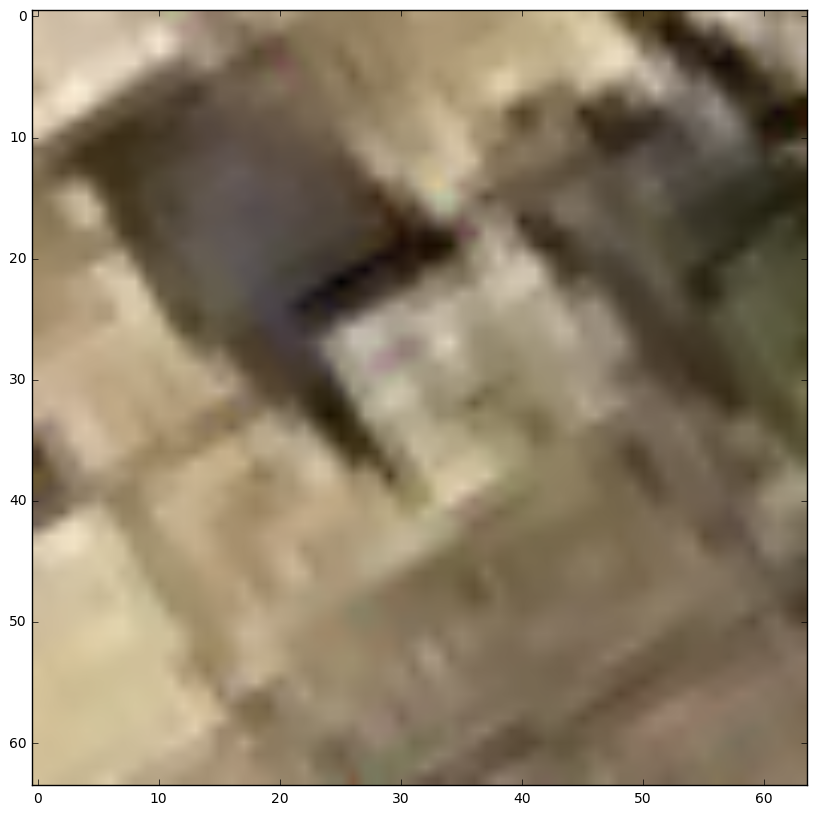

In [354]:
imshow(gtp.get_patch_xyr(x, y, 30)[:3].transpose(1,2,0))

In [355]:
print "Training set has ", len(gtp.train_pos), "raw positive samples and", len(gtp.train_neg), "raw negatives"
print "Testing set has ", len(gtp.test_pos), "raw positive samples and", len(gtp.test_neg), "raw negatives"

Training set has  177 raw positive samples and 158 raw negatives
Testing set has  19 raw positive samples and 19 raw negatives


In [ ]:
# patch, labels = gtp.random_positive(rotate=True)
patch, labels = gtp.random_sample(rotate=True)

figsize(10,10)
subplot(1,2,1)
imshow(patch[:3].transpose(1,2,0))
grid()
title('colors')

subplot(1,2,2)
im = clip(patch[3:].transpose(1,2,0)/10., 0, 1)
imshow(im)
title('densities');
grid(color='yellow')
display(DataFrame([labels], columns=data_provider.Predictions._fields))

generated positive, index=98


,x,y,label,dx,dy,angle
0,233194.24301,252531.965619,1,0,0,-171.530501


Box?:  1


,x,y,label,dx,dy,angle
0,232751.445026,252451.231072,1,0,-0,49.15567


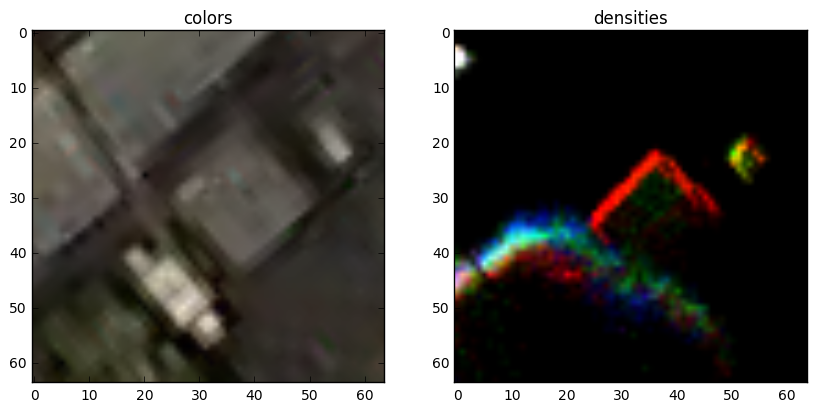

In [301]:
print 'Box?: ',labels.label
subplot(1,2,1)
imshow(patch[:3,:,:].transpose(1,2,0).clip(0,1))
title('colors')

subplot(1,2,2)
imshow((patch[3:,:,:]/20).transpose(1,2,0).clip(0,1))
title('densities')

display(DataFrame([labels], columns=data_provider.Predictions._fields))

# Making LMDB 

In [18]:
def make_datum(patch, labels):
     #Create a Datum
    datum = Datum()
    datum.channels, datum.height, datum.width = patch.shape
    datum.float_data.extend(patch.astype(np.float64).flat)
    if isinstance(labels, int):
        datum.label = labels
    else:
        datum.label = labels.label
    return datum

In [19]:
from tqdm import tnrange
import lmdb
# conda install -c https://conda.binstar.org/dougal lmdb
from caffe.proto.caffe_pb2 import Datum
#datums = []
#sdata = []
def make_lmdb(dbname, nsamples, data_generator):
    train_data_env = lmdb.open(dbname)
    train_data_env.set_mapsize(1e12)
 
    for i in tnrange(nsamples):
        sample = data_generator.random_sample()
        datum = make_datum(sample.data, sample.predicted)
        # datums.append(datum)
        # sdata.append(sample.data)
        #print datum.label
        key = '{:06}{:06}'.format(int(100 * sample.predicted.x), int(100 * sample.predicted.y))
        with train_data_env.begin(write=True) as txn:
            print '\r', key,
            txn.put(key, datum.SerializeToString())
        #print

In [22]:
!rm -r /home/femianjc/shared/srp/test1_lmdb
make_lmdb('/home/femianjc/shared/srp/test1_lmdb', 1000, gtp)

2328645125216286



In [23]:
lmdb_env = lmdb.open('/home/femianjc/shared/srp/test1_lmdb')
txn = lmdb_env.begin()
cur = txn.cursor()

# Test Generated Classifier

It should be safe to start executing cells from here.

In [79]:
%pylab  inline
import os
import sys

Populating the interactive namespace from numpy and matplotlib


/home/femianjc/anaconda2/envs/femiani/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['info']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [25]:
import data_provider
reload(data_provider)
DataProvider = data_provider.DataProvider

gtp = DataProvider()

In [137]:
import sys
sys.path.insert(0, '/home/femianjc/src/caffe/distribute/python/')
import caffe

caffe.set_device(0)
caffe.set_mode_gpu()

### *Remember to execute /home/femianjc/src/caffe/env.sh*

## Poke the net

In [424]:
%%file box_classifier.py

from collections import namedtuple
import os
import sys
import numpy as np

# Import caffe and complain loudly if it is misconfigured
try:
    import caffe
except:
    raise ImportError("Caffe not found -- you need to put 'caffe/distribute/python/' in the PYTHONPATH or in `sys.path`")


Result = namedtuple('Result', ['label', 'probs'])

class BoxClassifier(object):
    def __init__(self, use_gpu=True, device=0):
        super(BoxClassifier, self).__init__()
        self.use_gpu = use_gpu          
        self.device = device
        caffe.set_device(device)
       
        if use_gpu:
            caffe.set_mode_gpu() 

        # Load the one and only CAFFE classifier for boxes
        root = os.path.dirname(__file__)
        self.net = caffe.Net(os.path.join(root, 'lenet.prototxt'), 
                             os.path.join(root, 'snapshots_highres/_iter_214581.caffemodel'),
                             caffe.TEST)
    def classify(self, boxes):
        if len(boxes.shape) == 3:
            boxes = np.array([boxes])
        
        if self.net.blobs['data'].num != len(boxes):
            self.net.blobs['data'].reshape(*boxes.shape)
            self.net.reshape()
        probs = self.net.forward(data=boxes)['prob']
        label = probs.argmax(1)
        return Result(label=label, probs=probs)
                             
    def __call__(self, boxes):
        return self.classify(boxes) 

Overwriting box_classifier.py


In [425]:
import box_classifier
reload(box_classifier)

cls= box_classifier.BoxClassifier()

In [426]:
TP = TN = FP = FN = 0.
for i in range(1000):
    patch, label = gtp.random_sample()
    result = cls(patch)
    if label.label == 1 and result.label[0] == 1:
        TP += 1
    elif label.label == 1 and result.label[0] == 0:
        FN += 1
    elif label.label == 0 and result.label[0] == 1:
        FP += 1
    elif label.label == 0 and result.label[0] == 0:
        TN += 1

C = matrix([[TP, FN], [FP, TN]])
print 'C:'
print C

C:
[[ 448.   83.]
 [   3.  466.]]


In [427]:
print 'acc:', float(TP + TN)/(TP + FP + TN + FN)
print 'recall:', float(TP)/(TP + FN)
print 'precision', float(TP)/(TP + FP)

acc: 0.914
recall: 0.843691148776
precision 0.993348115299


**Does it say 'yes' to positive samples?**

label [1]
pobs [[ 0.  1.]]


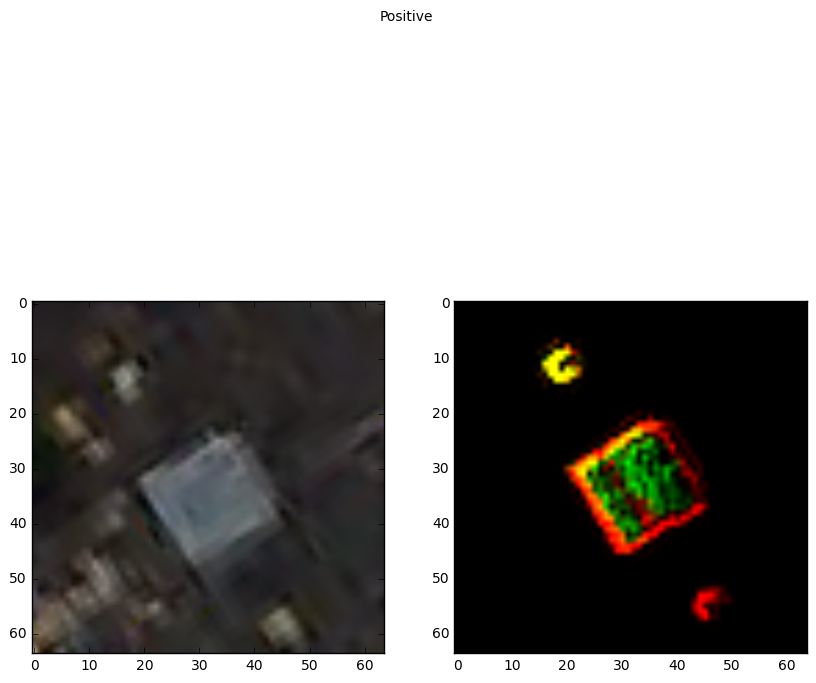

In [378]:
patch, info = gtp.random_positive()

result = cls(patch)
subplot(121); imshow(patch[:3].transpose(1,2,0).clip(0,1))
subplot(122); imshow((patch[3:].transpose(1,2,0)/10).clip(0,1))
suptitle('Positive' if result.label[0] else 'Negative')

print 'label', result.label
print 'pobs', result.probs.round(2)


### Checking Net output for a small testing area

In [379]:
import rasterio
import skimage.transform

In [401]:
window=((27000,31000), (27000,31000))
# window=((23000,27000), (20000,24000))
stack = gtp.densities.read(window=window, boundless=True)
tfm = gtp.densities.window_transform(window)
bounds = gtp.densities.window_bounds(window)

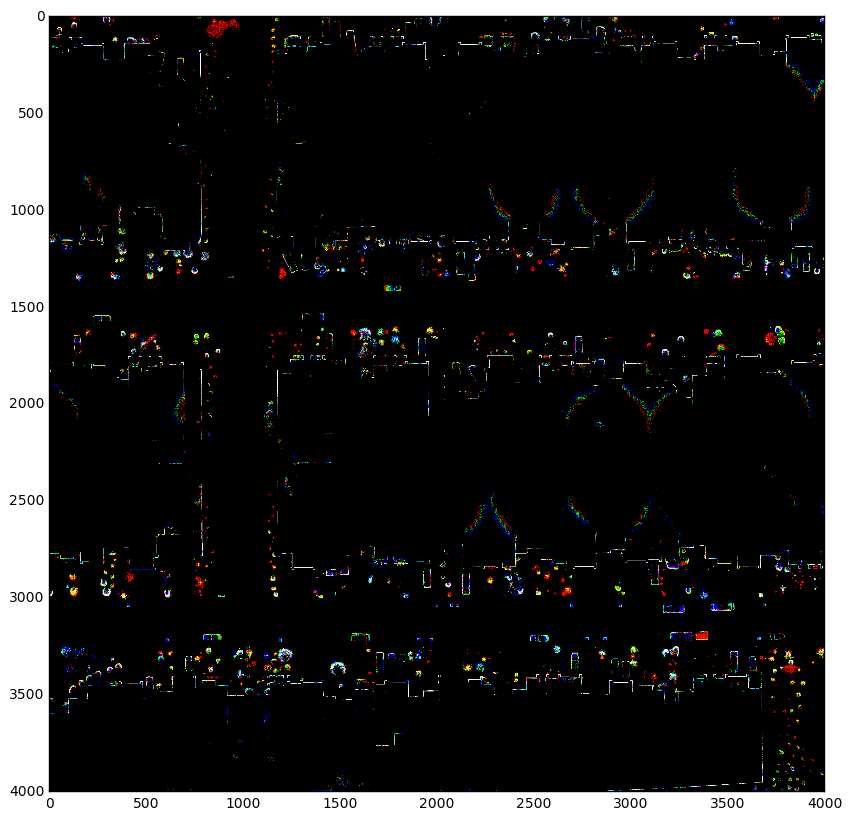

In [402]:
# This is the raster of that area
figsize(10, 10)
imshow((stack).transpose(1,2,0))

In [403]:
#CRS is recoreded incorrectly in the raster
pos_regions = rasterio.open('/home/femianjc/Projects/SRP/transformer_box/positive_regions/positive_regions-epsg26949.tif')

In [404]:
stack[:2].shape

(2, 4000, 4000)

In [405]:
mask = stack[:2].sum(0) > 0

mask[:32,:] = 0
mask[:,:32] = 0
mask[-32:,:] = 0
mask[:,-32:] = 0

In [406]:
pos_window = pos_regions.window(*bounds, boundless=True)
pos_data = pos_regions.read(1, window=pos_window, boundless=True).astype(np.uint8)

In [407]:
pos_data = skimage.transform.resize(pos_data, mask.shape, order=0)

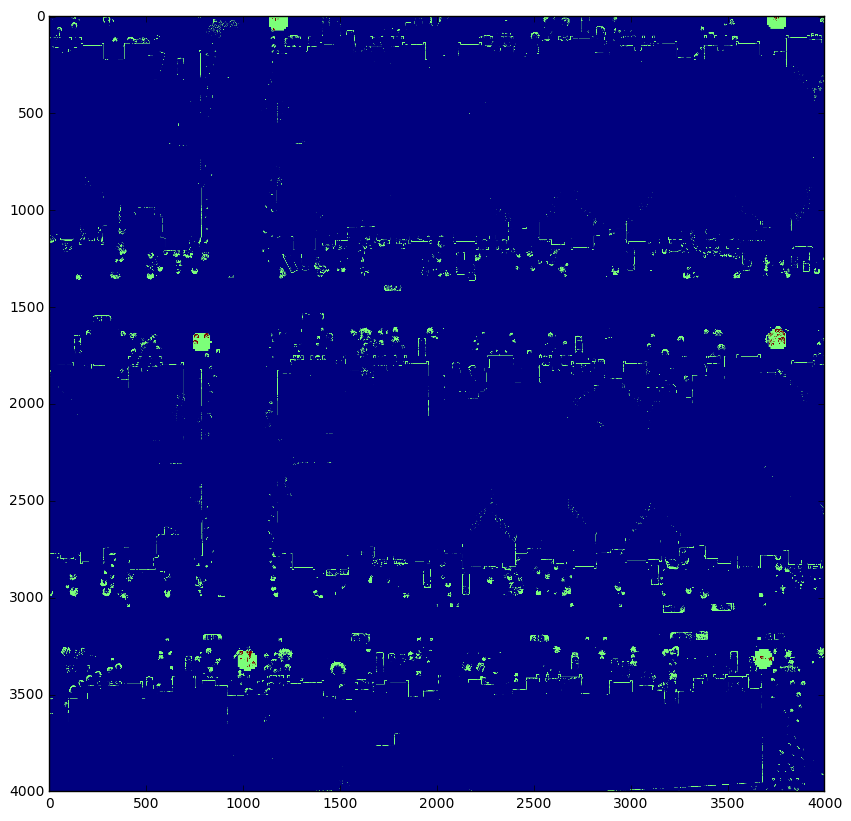

In [408]:
imshow(pos_data + (stack.sum(0) > 2))

<matplotlib.colorbar.Colorbar instance at 0x7f03d18e83b0>

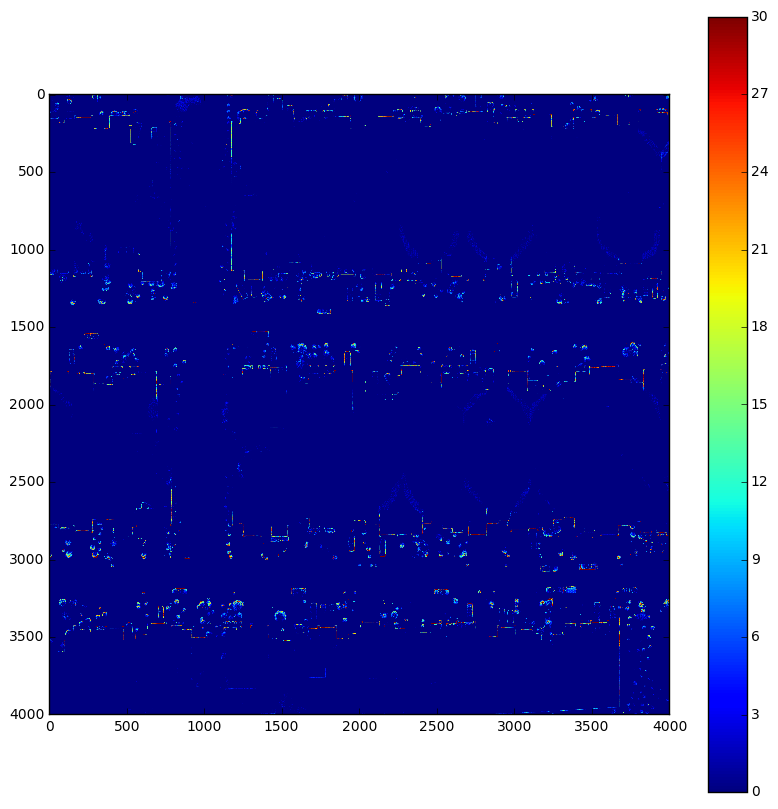

In [409]:
imshow(stack.sum(0), vmax=30)
colorbar()

In [410]:
import skimage.segmentation

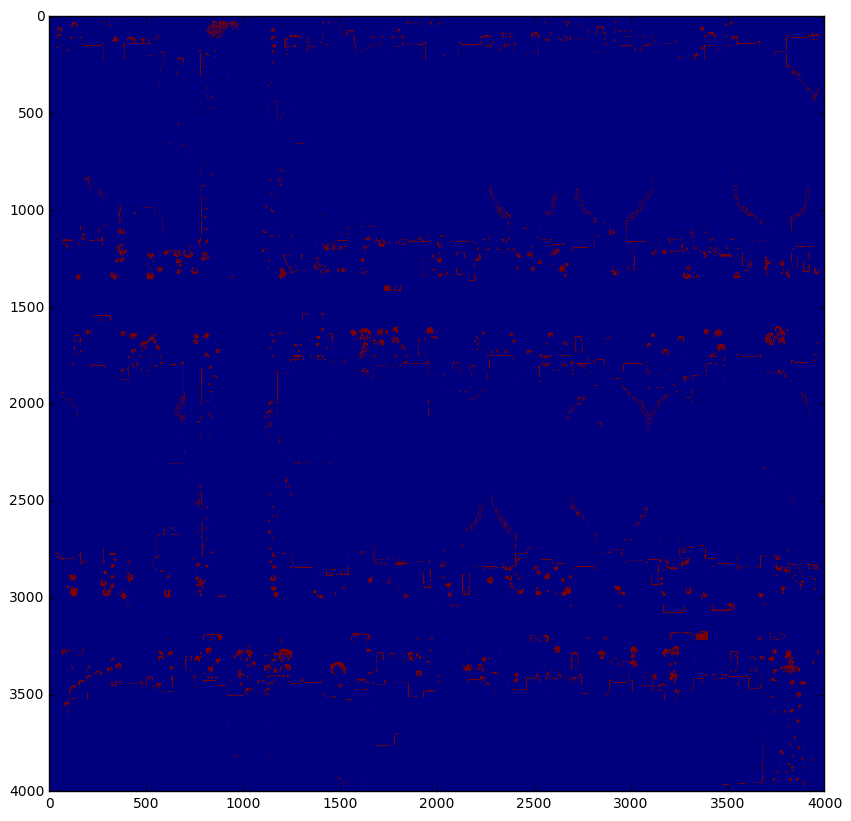

In [411]:
imshow(mask)

In [412]:
locations = np.column_stack(np.where(mask))
locations = np.roll(locations, 1,1)

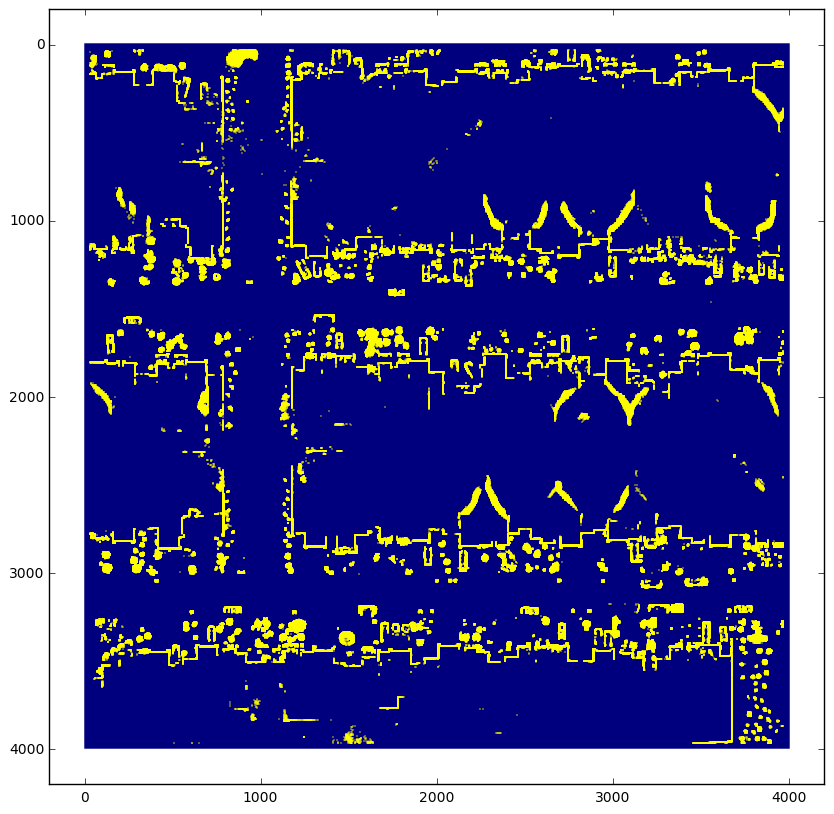

In [413]:
imshow(np.zeros_like(mask))
scatter(locations[:,0], locations[:,1], lw=0, s=1,c='yellow')

In [414]:
output = np.zeros_like(mask, dtype=np.float32)

In [415]:
locations2 = array(tfm*locations.T).T

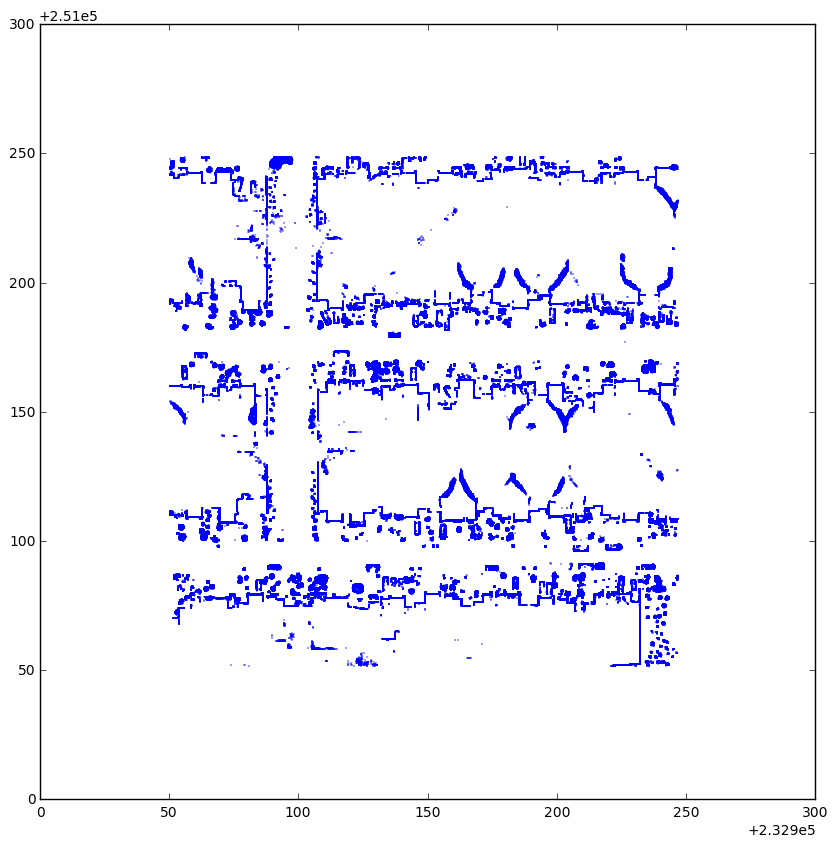

In [416]:
scatter(locations2[:,0], locations2[:,1], lw=0, s=1,)

In [417]:
FP = []
FN = []
BATCH_SIZE=400
for i in range(0,len(locations),BATCH_SIZE):
    actual = array([pos_data[loc[1], loc[0]] for loc in locations[i:i+BATCH_SIZE]]).astype(bool)
    batch = array([gtp.get_patch_xy(loc[0], loc[1]) for loc in locations2[i:i+BATCH_SIZE]])
    res = cls(batch)
    predicted = res.label.astype(bool)
    
    false_neg_indexes = where(actual & ~predicted)[0] + i
    false_pos_indexes = where(~actual & predicted)[0] + i
    FP += false_pos_indexes.tolist()
    FN += false_neg_indexes.tolist()
    
    scores = res.probs[:,1]
    output[(locations[i:i+BATCH_SIZE,1], locations[i:i+BATCH_SIZE,0])] = scores
    if i%1000 == 0:
        print '\r', i, 'of', len(locations), '   --    {:3}%'.format((100*i)/len(locations)),
print "100% !!!"

312000 of 312786    --     99% 100% !!!


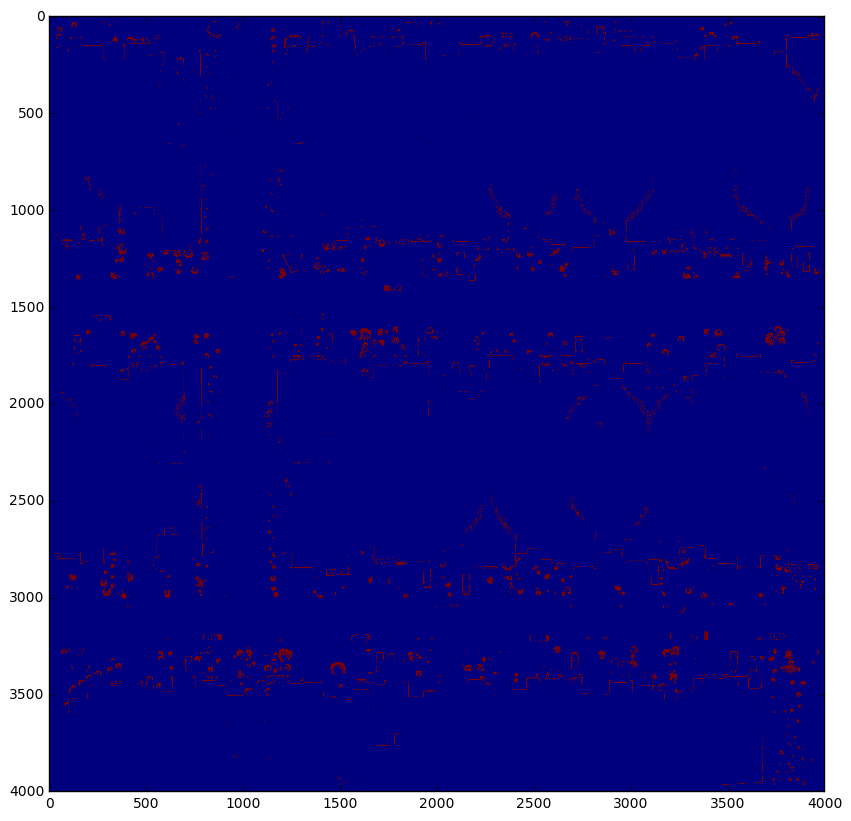

In [418]:
imshow(output > 0)

In [419]:
# Save the classifier scores to a file with identical settings to gtp.densities (but with float16/1 channel)
prof = dict(gtp.densities.profile)
prof.update(dtype=rasterio.float32, 
            count=1, 
            driver=u'GTiff',  
            width=output.shape[1], 
            height=output.shape[0], 
            transform=tfm,
           nodata=0)
path = 'results-{}-{}--{}-{}.tif'.format(*bounds)
output_file = rasterio.open(path, 'w',  **prof)
output_file.write_band(1, output)
output_file.close()
print path
    

results-232948.606098-251050.107712--233148.399518-251250.093696.tif


In [420]:
print 'FP:', len(FP)
print 'FN:', len(FN)

FP: 313
FN: 6234


Add the errors to the LMDB for training later on

In [421]:
print "acc was:", 100*float(len(locations)-len(FP)-len(FN))/len(locations)

acc was: 97.9068756274


In [422]:
def show_lidar(stack):
    img = stack[3:].transpose(1,2,0).copy()
    img /= min(1, img.mean() + img.std())
    img = img.clip(0,1)
    imshow(img)

In [423]:
from tqdm import tnrange
import lmdb
from caffe.proto.caffe_pb2 import Datum

def append_lmdb(dbname, neg_locations, pos_locations, data_generator):
    
    labels = [0.]*len(neg_locations) + [1.]*len(pos_locations)
    samples =  np.c_[np.concatenate([neg_locations, pos_locations]), labels]
        
    train_data_env = lmdb.open(dbname)
    train_data_env.set_mapsize(1e12)
    for i in tnrange(len(samples)):
        (x, y, label) = samples[i]
        data = data_generator.get_patch_xy(x, y)
        datum = make_datum(data, int(label))
        key = '{:06}{:06}'.format(int(100 * x), int(100 * y))
        with train_data_env.begin(write=True) as txn:
            print '\r', key,
            txn.put(key, datum.SerializeToString())

append_lmdb('/home/femianjc/shared/srp/ds1_lmdb', 
            locations2[array(FP,dtype=int)], 
            locations2[array(FN,dtype=int)], 
            gtp )

2330004025108175



In [330]:
# Here we make ds2_lmdb which includes training data generated primarily from the test area 2
!rm -r /home/femianjc/shared/srp/ds2_lmdb
make_lmdb('/home/femianjc/shared/srp/ds2_lmdb', 5000, gtp)
append_lmdb('/home/femianjc/shared/srp/ds2_lmdb', 
            locations2[array(FP,dtype=int)], 
            locations2[array(FN,dtype=int)], 
            gtp )

2321038325247710
2327494625126624



In [325]:
import fiona

In [326]:
expected = [0.]*len(FP) + [1.]*len(FN)
predicted = [1.]*len(FP) + [0.]*len(FN)
samples =  np.c_[np.concatenate([locations2[FP], locations2[FN]]), expected, predicted]

In [327]:
print samples

[[  2.32684529e+05   2.51447330e+05   0.00000000e+00   1.00000000e+00]
 [  2.32684579e+05   2.51447330e+05   0.00000000e+00   1.00000000e+00]
 [  2.32684629e+05   2.51447330e+05   0.00000000e+00   1.00000000e+00]
 ..., 
 [  2.32749462e+05   2.51266293e+05   1.00000000e+00   0.00000000e+00]
 [  2.32749562e+05   2.51266293e+05   1.00000000e+00   0.00000000e+00]
 [  2.32749462e+05   2.51266243e+05   1.00000000e+00   0.00000000e+00]]


In [328]:
records = [{'geometry': {'coordinates': (x, y),'type': 'Point'}, 'id':idx,  
            'properties':{'expected':int(expected), 'predicted':predicted }} 
           for (idx, (x,y,expected, predicted)) in enumerate(samples)]
records[0]

{'geometry': {'coordinates': (232684.52914455513, 251447.32987258857),
  'type': 'Point'},
 'id': 0,
 'properties': {'expected': 0, 'predicted': 1.0}}

In [329]:
!rm out.geojson
out = fiona.open('out.geojson', 'w', 
                driver='GeoJSON',
                crs=gtp.densities.crs_wkt, 
                schema={'geometry': 'Point', 
                        'properties': [('expected', 'int'), ('predicted', 'int')]} 
               )
    

out.writerecords(records)
out.close()

In [186]:
mask[(locations[array(FP,dtype=int),0].T, locations[array(FP,dtype=int),1].T)]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False], dtype=bool)

In [187]:
print os.path.abspath('results-{}-{}--{}-{}.tif'.format(*bounds))

/home/femianjc/Projects/SRP/transformer_box/results-232948.606098-251050.107712--233148.399518-251250.093696.tif


In [188]:
print output.shape
print gtp.densities.height, gtp.densities.width
print prof

(4000, 4000)
32002 33034
{'count': 1, 'crs': {'init': u'epsg:26949'}, 'dtype': 'float32', 'affine': Affine(0.049948355054722254, 0.0, 231600.00051125194,
       0.0, -0.049996496002872315, 252599.9990879348), 'driver': u'GTiff', 'transform': Affine(0.049948355054722254, 0.0, 232948.60609772944,
       0.0, -0.049996496002872315, 251250.09369585724), 'height': 4000, 'width': 4000, 'blockxsize': 128, 'tiled': True, 'blockysize': 128, 'nodata': 0}


In [189]:
print locations2.min(0)
print locations2.max(0)

[ 232950.20444509  251051.75759621]
[ 233146.75122223  251248.49380799]


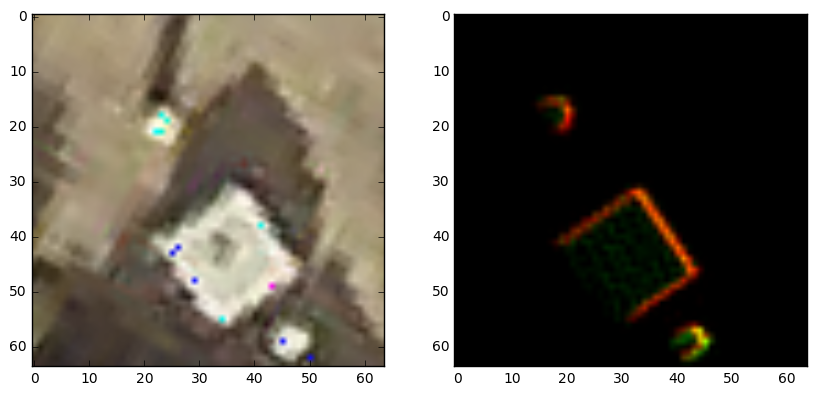

In [214]:
p = gtp.get_patch_xyr(231929.595277, 252296.944382, 30)
subplot(121)
imshow(p[:3].transpose(1,2,0))
subplot(122)
imshow((p[3:].transpose(1,2,0)/40).clip(0,1))


In [191]:
cls(p)

Result(label=array([1]), probs=array([[  4.96462064e-07,   9.99999523e-01]], dtype=float32))

In [192]:
cls(patch)

Result(label=array([0]), probs=array([[ 1.,  0.]], dtype=float32))

In [1]:
import sys
sys.path.insert(0, '/home/femianjc/src/caffe/distribute/python/')
import caffe

caffe.set_device(0)
caffe.set_mode_gpu()

In [2]:
%%file sample.prototxt

layer {
  name: "data"
  type: "Python"
  top: "data"
  top: "isbox"
  top: "xy"
  top: "angle"
  include {
    phase: TRAIN      
  }
  python_param {
    module: "python_layers"
    layer: "BoxInputLayer"
    param_str:"dict(num=128, phase=\'TRAIN\')"
  }
}
layer {
  name: "data"
  type: "Python"
  top: "data"
  top: "isbox"
  top: "xy"
  top: "angle"
  include {
    phase: TEST      
  }
  python_param {
    module: "python_layers"
    layer: "BoxInputLayer"
    param_str:"dict(num=128, phase=\'TEST\')"
  }
}


## how to handle test data?

#######
# Start of existing network here
# (Excludinng its data  layers of course)
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 0 #1
  }
  param {
    lr_mult: 0 #2
  }
  convolution_param {
    num_output: 20
    kernel_size: 5
    stride: 1
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  param {
    lr_mult: 0 #1
  }
  param {
    lr_mult: 0 # 2
  }
  convolution_param {
    num_output: 50
    kernel_size: 5
    stride: 1
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "drop_p2"
  type: "Dropout"
  bottom: "pool2"
  top: "pool2"
  dropout_param {
    dropout_ratio: 0.5
  }
  include {
    phase: TRAIN
  }
}
layer {
  name: "ip1"
  type: "InnerProduct"
  bottom: "pool2"
  top: "ip1"
  param {
    lr_mult: 0 #1
  }
  param {
    lr_mult: 0 #2
  }
  inner_product_param {
    num_output: 500
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "ip1"
  top: "ip1"
}
layer {
  name: "drop_ip1"
  type: "Dropout"
  bottom: "ip1"
  top: "ip1"
  dropout_param {
    dropout_ratio: 0.5
  }
  include {
    phase: TRAIN
  }
}

# End of pre-existing network here
# (Excluding the last loss layer etc. of cours)
# Also exclude the finala IP layer, unless you want to replace 'top_isbox' by it. 
####################





layer {
  name: "top_isbox"
  type: "InnerProduct"
  bottom: "ip1"       # <----  Rename this to the top of the pre-existing CNN
  top: "top_isbox"     
  param {
    lr_mult: 1
  }
  param {
    lr_mult: 2
  }
  inner_product_param {
    num_output: 2
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}

layer {
  name: "top_angle"
  type: "InnerProduct"
  bottom: "ip1"        # <----  Rename this to the top of the pre-existing CNN
  top: "top_angle"
  param {
    lr_mult: .1
  }
  param {
    lr_mult: .2
  }
  inner_product_param {
    num_output: 2
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}

layer {
  name: "top_xy"
  type: "InnerProduct"
  bottom: "ip1"   # <----  Rename this to the top of the pre-existing CNN
  top: "top_xy"
  param {
    lr_mult: .1
  }
  param {
    lr_mult: .2
  }
  inner_product_param {
    num_output: 2
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}

layer {
  name: "isbox_loss"
  type: "SoftmaxWithLoss"
  bottom: "top_isbox"
  bottom: "isbox"
  top: "isbox_loss"
  loss_weight: 1
}

layer {
    name: "angle_filter"
    type: "Filter"
    bottom: "top_angle"
    bottom: "angle"
    bottom: "isbox"
    top: "top_angle_filter"
    top: "angle_filter"
}

layer {
    name: "xy_filter"
    type: "Filter"
    bottom: "top_xy"
    bottom: "xy"
    bottom: "isbox"
    top: "top_xy_filter"
    top: "xy_filter"
}

layer {
  name: "angle_loss"
  type: "EuclideanLoss"
  bottom: "top_angle_filter"
  bottom: "angle_filter"
  top: "angle_loss"
  loss_weight: 1
}


layer {
  name: "xy_loss"
  type: "EuclideanLoss"
  bottom: "top_xy_filter"
  bottom: "xy_filter"
  top: "xy_loss"
  loss_weight: 0.001
}
layer {
  name: "accuracy"
  type: "Accuracy"
  bottom: "top_isbox"
  bottom: "isbox"
  top: "acc"
}


Overwriting sample.prototxt


In [3]:
%%file python_layers.py 

import sys, os
import caffe
import rasterio
import numpy as np
import skimage.util
import data_provider

sys.stdout.write('creating gtp')
gtp = data_provider.DataProvider()
sys.stdout.write('it is done')

class BoxInputLayer(caffe.Layer):
    def setup(self,bottom,top):
        # read parameters from `self.param_str`
        params = eval(self.param_str)
        # self.combined_path = params['raster'] # location of a small-ish file with rasterized label into. 
        # self.size = params['size']  # window size (width, height)
        self.num = params.get('num', 8)   # batch size, default is 8
        # self.height_jitter = params.get('height_jitter', 1.0)   # jitter heights (uniform distr.)
        self.rotate = params.get('rotate', True)   # Apply random rotations
        self.size = 2 * gtp.radius_in_pixels
        self.translate = params.get('translate', self.size)   # Apply random rotations
        self.phase = params.get('phase', 'TRAIN')
        print "I was! I was set up!"
    
    def reshape(self,bottom,top):
        # no "bottom"s for input layer
        if len(bottom)>0:
            raise Exception('cannot have bottoms for input layer')
    
        assert len(top) ==len(['data', 'isbox', 'xy', 'angle'])
        top[0].reshape(self.num, 6, self.size, self.size) # reshape the outputs to the proper sizes       
        top[1].reshape(self.num) # Present or not (box=1, not-box=0)
        top[2].reshape(self.num, 2) # dx, dy
        top[3].reshape(self.num, 2) # angle (as cos, sin)
        
        
        # print "I was reshaped, I now have shape ", tuple(top[0].shape)

    def forward(self,bottom,top): 
        sys.stdout.write('D')
        sys.stdout.flush()
        for i in range (self.num):
            sample = gtp.random_sample(rotate=self.rotate, jitter=self.translate, train=(self.phase=='TRAIN'))
            
            top[0].data[i, :, : ,:] = sample.data
            top[1].data[i] = sample.predicted.label
            top[2].data[i, 0] = sample.predicted.dx
            top[2].data[i, 1] = sample.predicted.dy
            top[3].data[i, 0] = np.cos(np.radians(sample.predicted.angle))
            top[3].data[i, 1] = np.sin(np.radians(sample.predicted.angle))
                        
        sys.stdout.write('E')
        sys.stdout.flush()
        

    def backward(self, top, propagate_down, bottom):
        # no back-prop for input layers
        pass



Overwriting python_layers.py


In [233]:
import data_provider
reload (data_provider)
import python_layers
reload (python_layers)

creating gtpit is done

<module 'python_layers' from 'python_layers.pyc'>

In [5]:
%%file solver.prototxt

# The train/test net protocol buffer definition
net: "sample.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_initialization: false
test_iter: 2
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.001
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 1
clip_gradients: 25
# The maximum number of iterations
max_iter: 1000000
# snapshot intermediate results
snapshot: 100
snapshot_prefix: "./newNet/"
# solver mode: CPU or GPU
solver_mode: GPU


Overwriting solver.prototxt


In [6]:
solver = caffe.get_solver('solver.prototxt')

I was! I was set up!
I was! I was set up!


In [8]:
onet = caffe.Net('./lenet_train_test_adapted.prototxt', caffe.TEST, weights='./snapshots_highres/_iter_214581.caffemodel')

In [21]:
onet.forward()

{'accuracy': array(0.9599999785423279, dtype=float32),
 'loss': array(0.07738299667835236, dtype=float32)}

In [22]:
onet.params

OrderedDict([('conv1', <caffe._caffe.BlobVec at 0x7f193f09e130>),
             ('conv2', <caffe._caffe.BlobVec at 0x7f193f09e1a0>),
             ('ip1', <caffe._caffe.BlobVec at 0x7f193f09e210>),
             ('ip2', <caffe._caffe.BlobVec at 0x7f193f09e280>)])

In [234]:
snet = caffe.Net('sample.prototxt', caffe.TEST, weights='./snapshots_highres/_iter_214581.caffemodel')

I was! I was set up!


In [235]:
for k in snet.params:
    print k
    for i in range(len(solver.net.params[k])):
        solver.net.params[k][i].data[...] = snet.params[k][i].data[...]

conv1
conv2
ip1
top_isbox
top_angle
top_xy


In [236]:
snet.params['top_isbox'][0].data[...] = onet.params['ip2'][0].data[...]
snet.params['top_isbox'][1].data[...] = onet.params['ip2'][1].data[...]

In [237]:
solver.snapshot()

In [238]:
import os
snapshots = os.listdir('./newNet/')
snapits = [int(os.path.splitext(s)[0][6:]) for s in snapshots]
print max(snapits)

1872


In [69]:
solver.restore('./newNet/_iter_{}.solverstate'.format(max(snapits)))

In [72]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [296]:
snet.forward()

DE

{'acc': array(0.515625, dtype=float32),
 'angle_loss': array(242540992.0, dtype=float32),
 'isbox_loss': array(8.77032470703125, dtype=float32),
 'xy_loss': array(358627424.0, dtype=float32)}

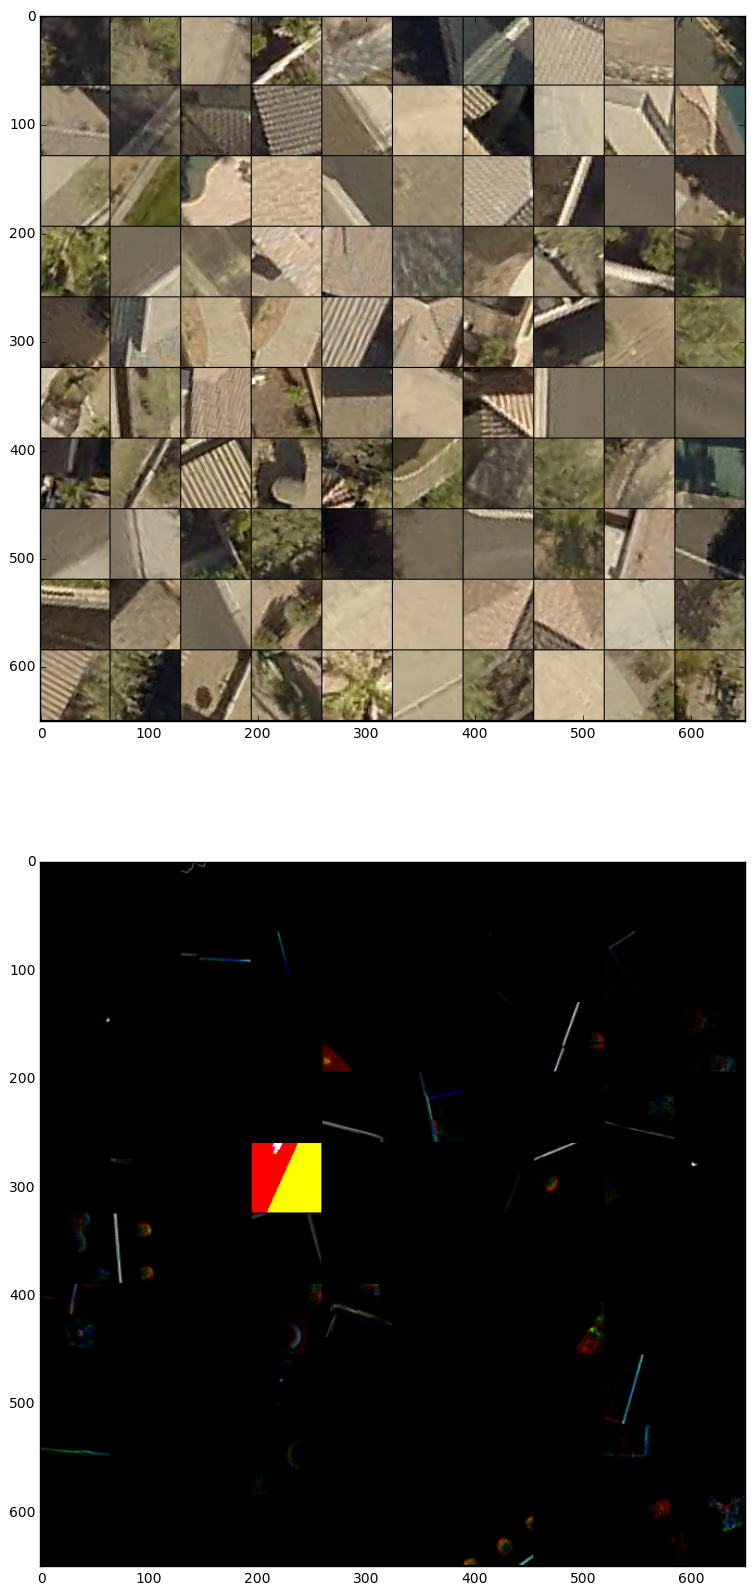

In [297]:
from skimage.util import view_as_blocks

def gridpic(m, n, blobdata, channels=(0, 1, 2), scale=1.0):
    num, source_channels, height, width = blobdata.shape
    assert m*n <= num
    assert 0 <= min(channels) and max(channels) < source_channels
    bigpic = np.zeros((3, m*height+m, n*width+n))
    blocks = view_as_blocks(bigpic, (3, height+1, width+1))[0]
    blocks[:m,:n, :3, :height,:width] = clip(blobdata[:m*n,channels].reshape(m, n, 3, height, width)*scale, 0, 1)
    return bigpic.transpose(1,2,0)

# imshow(onet.blobs['data'].data[2, :3].transpose(1,2,0))
#imshow(gridpic(10, 10, snet.blobs['data'].data, channels=(0,1,2), scale=1./40.))
figsize(10, 20)
subplot(211)
imshow(gridpic(10, 10, snet.blobs['data'].data, channels=(0,1,2), scale=1))
subplot(212)
imshow(gridpic(10, 10, snet.blobs['data'].data, channels=(3,4,5), scale=1/40.))

In [33]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


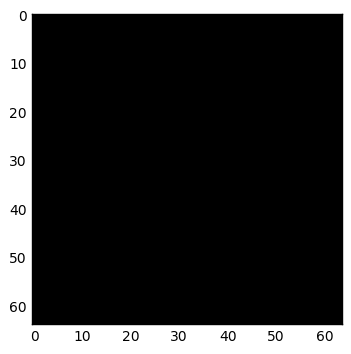

In [39]:
imshow(snet.blobs['data'].data[0, :3].transpose(1,2,0))

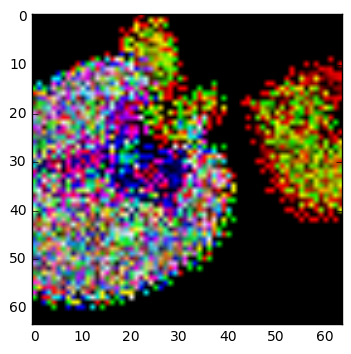

In [37]:
imshow(onet.blobs['data'].data[0, 3:].transpose(1,2,0))

In [28]:
snet.forward()

DE

{'acc': array(0.453125, dtype=float32),
 'angle_loss': array(56.751800537109375, dtype=float32),
 'isbox_loss': array(42.47796630859375, dtype=float32),
 'xy_loss': array(4063.127685546875, dtype=float32)}

In [73]:
solver.net.forward()

DE

{'acc': array(0.4609375, dtype=float32),
 'angle_loss': array(260.2896728515625, dtype=float32),
 'isbox_loss': array(4.3118205070495605, dtype=float32),
 'xy_loss': array(5066.837890625, dtype=float32)}

In [9]:
from IPython.display import display, clear_output

In [24]:
ys = []
xs = []
aloss = [] 
xyloss = []

In [25]:
def total_loss(net):
    total = 0
    for b in net.outputs:
        v = float(net.blobs[b].data[...])
        w = net.blob_loss_weights[b]
        total += w*v
    return total

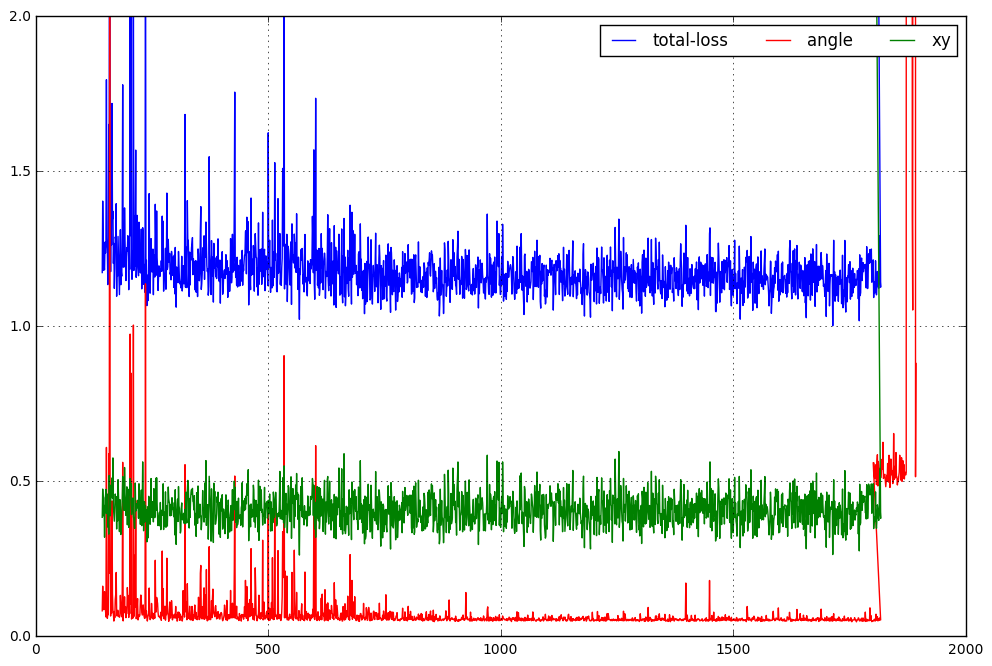

D

KeyboardInterrupt: 

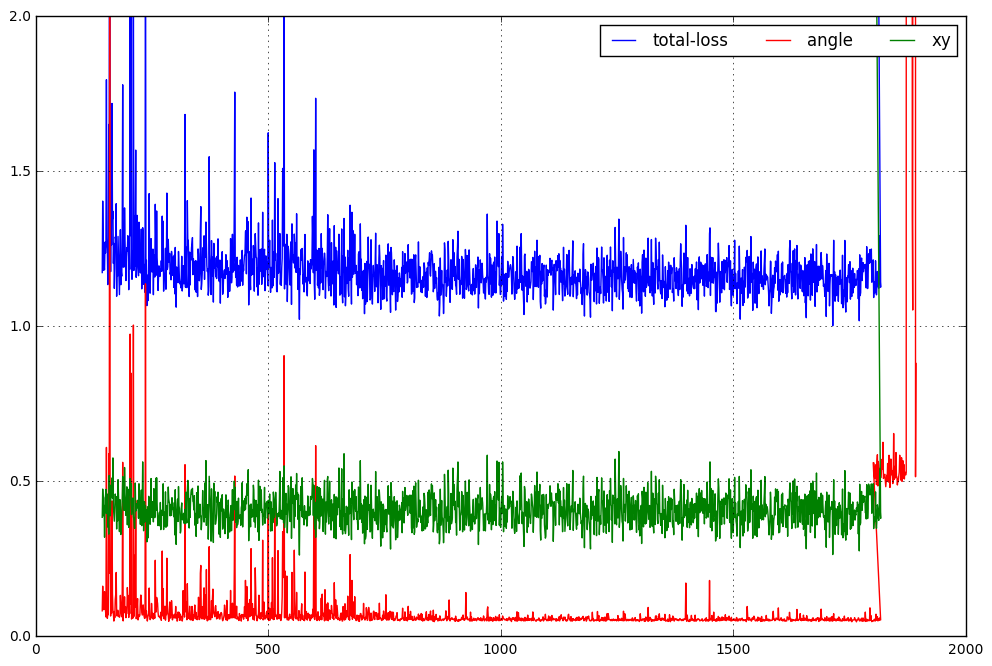

In [61]:
figsize(12, 8)
for i in range(10000):
    solver.step(1)
    ys.append( total_loss(solver.net))
    aloss.append( float(solver.net.blobs['angle_loss'].data[...])*solver.net.blob_loss_weights['angle_loss'])
    xyloss.append( float(solver.net.blobs['xy_loss'].data[...])*solver.net.blob_loss_weights['xy_loss'])
    xs.append(solver.iter)
    clf()
    plot(xs, ys, c='blue', label='total-loss')
    plot(xs, aloss, c='red', label='angle')
    plot(xs, xyloss, c='green', label='xy')
    legend(ncol=3)
    ylim(0, 2)
    grid()
    clear_output(wait=True)
    display(gcf())
clear_output()

In [23]:
total_loss(solver.net)

1.2497922707197073

In [31]:

solver.net.blobs['acc'].data[...]

array(0.59375, dtype=float32)

In [38]:
def to_angles(a):
    return np.degrees(np.arctan2(a[:,1], a[:,0]))

In [40]:
to_angles(solver.net.blobs['angle'].data)

array([ -92.99999237,   25.99999809,  -89.97670746,  -92.99999237,
         -6.65737581,   97.99999237,  173.        ,  121.99998474,
        -33.        ,   21.99999619,  -74.34500885, -175.99998474,
       -127.18591309,  -26.3126545 ,   -5.        ,   46.99999619,
          0.99999982,  -15.79012585,  -56.99999619,  -29.62294197,
        141.05201721,  -85.2697525 ,  -49.        , -105.44702148,
        175.        ,  -97.99999237, -143.15841675, -176.92391968,
        -96.65737152,  -49.99999237,  -81.12745667, -107.48262787,
         28.77408218,  -35.85359573,   62.71355057,  176.65498352,
        171.89460754,  137.        ,   -9.36790943,   80.99999237,
        -11.53050137,   75.99999237,  110.99999237,  127.        ,
        114.65853119,   45.65853882,  132.        ,  156.99998474,
        151.11064148,   28.40666771,  -78.        ,  178.        ,
         90.11553955,  -51.99999619,  -69.05996704,  117.3383255 ,
        160.52027893,  165.37705994,  121.93599701, -119.15840

In [39]:
to_angles(solver.net.blobs['top_angle'].data)

array([ -44.38101578,  117.79873657,   -0.85265017, -133.24136353,
        170.49252319,  113.8411026 ,  -92.36758423,   89.81802368,
        146.6545105 ,   55.95938873,   76.72841644,   92.44490814,
       -115.92464447,   81.45826721,   30.60334778,  -48.87960434,
        -13.33359528,   99.08348846,  -17.69961548, -106.0693512 ,
         19.69268799, -139.95930481,   90.44273376, -155.1506958 ,
       -117.01725006,  -66.07941437,  -74.41408539,  -98.35656738,
       -128.56106567, -102.87345886,  156.94529724, -107.17262268,
        -59.88261414, -170.91026306, -103.1497879 , -119.32752228,
        -85.55171204, -120.55966187,   48.04872894,  -72.41114044,
       -173.2494812 , -135.23912048,  -19.89723206, -128.73300171,
        -74.22386932, -108.88394165,  151.93865967,    2.72573924,
        -18.01379013, -108.70223236,  104.89739227,   72.47849274,
        110.02674103,  -47.88338852,   71.03338623,  124.35437775,
         27.06438065,   -4.5087924 , -175.48703003,  131.19834

In [45]:
MyNet = caffe.Net("sample.prototxt", caffe.TEST)

I was! I was set up!


In [46]:
outs = MyNet.forward()
outs

D

{'acc': array(0.609375, dtype=float32),
 'angle_loss': array(0.8800274729728699, dtype=float32),
 'isbox_loss': array(0.7479424476623535, dtype=float32),
 'xy_loss': array(3600.271240234375, dtype=float32)}

In [38]:
for k in outs:
    print k, ':', outs[k] * MyNet.blob_loss_weights[k]

acc : 0.0
angle_loss : 0.107487608604
isbox_loss : 0.878513634205
xy_loss : 0.415374159429


In [21]:
outs['isbox'].squeeze()

array([ 0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,
        0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,
        1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,
        1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,
        1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
        1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.], dtype=float32)